# CycleGAN for SVHN --> MNIST transfer
Adaptation of this [paper](https://arxiv.org/pdf/1703.10593.pdf) for transforming the SVHN domain to the MNIST one
Other papers used:

[1] **Instance Noise** : https://arxiv.org/pdf/1610.04490.pdf

[2] **Discriminator Regularizer** : https://arxiv.org/pdf/1705.09367.pdf

[3] **Gradient penalty** (DRAGAN) : https://arxiv.org/pdf/1705.07215.pdf

[4] **Instance normalization** : https://arxiv.org/abs/1607.08022

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import color, transform
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.gan.python.losses.python import losses_impl

from torchvision import datasets
from torchvision import transforms

from IPython.display import clear_output

/home/arthur/miniconda3/envs/tl-gpu/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the datasets

In [301]:
def normalize(x, max_value):
    """ Normalize the input between -1 and 1 """
    return (x / float(max_value)) * 2 - 1

### SVHN

In [4]:
svhn = datasets.SVHN(root="/home/arthur/datasets/svhn", download=False)

In [302]:
X_svhn = svhn.data
X_svhn = np.transpose(X_svhn, (0,2,3,1))
X_svhn = np.array([color.rgb2gray(im) for im in X_svhn])
X_svhn = normalize(X_svhn, 1)
X_svhn = X_svhn.reshape(len(X_svhn), 32, 32, 1)
Y_svhn = svhn.labels.flatten()%10
X_svhn.shape

(73257, 32, 32, 1)

### MNIST

In [6]:
mnist = input_data.read_data_sets('/home/arthur/datasets/mnist', one_hot=False)

Extracting /home/arthur/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/arthur/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/arthur/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/arthur/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [7]:
X_mnist = mnist.train.images
X_mnist = X_mnist.reshape(len(X_mnist), 28, 28)
X_mnist = np.array([transform.resize(im, [32,32]) for im in X_mnist])
X_mnist = normalize(X_mnist, 1)
X_mnist = X_mnist.reshape(len(X_mnist), 32, 32, 1)

/home/arthur/miniconda3/envs/tl-gpu/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [8]:
Y_mnist = mnist.train.labels
mlb = LabelBinarizer()
Y_mnist = mlb.fit_transform(Y_mnist)

In [317]:
X_source = X_mnist
Y_source = Y_mnist

X_target = X_svhn

## Create the model

In [10]:
batch_size = 64

### Useful functions

In [11]:
def leaky_relu(x):
    alpha = 0.05
    return tf.maximum(x, alpha * x)

In [12]:
def instance_normalization(x, name):
    with tf.variable_scope("instance_norm"):
        with tf.variable_scope(name):
            epsilon = 1e-5
            mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
            scale = tf.get_variable('scale',[x.get_shape()[-1]], 
                initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.02))
            offset = tf.get_variable('offset',[x.get_shape()[-1]],initializer=tf.constant_initializer(0.0))
            out = scale*tf.div(x-mean, tf.sqrt(var+epsilon)) + offset

            return out

In [13]:
def gaussian_noise_layer(input_layer, std):
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_layer + noise

### Placeholders

In [14]:
ipt_source = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name='ipt_source')
ipt_target = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name='ipt_target')
labels_source = tf.placeholder(tf.int32, shape=[None, 10], name="labels_source")

### Discriminator Network

In [15]:
def discriminator(x, scope): 
    initializer = tf.contrib.layers.xavier_initializer()

    with tf.variable_scope(scope + "/discriminator", reuse=tf.AUTO_REUSE):
        # Layer 1: 32x32x1 --> 16x16x64 (n=1 or 3)
        conv1 = tf.layers.conv2d(x, 64, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv1 = instance_normalization(conv1, "conv1")
        
        # Layer 2: 16x16x64 --> 8x8x128        
        conv2 = tf.layers.conv2d(conv1, 128, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv2 = instance_normalization(conv2, "conv2")
        
        # Layer 3: 8x8x128 --> 4x4x256    
        conv3 = tf.layers.conv2d(conv2, 256, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv3 = instance_normalization(conv3, "conv3")
        
        # Layer 4: 4x4x256 --> 2x2x512    
        conv4 = tf.layers.conv2d(conv3, 512, [5,5], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        conv4 = instance_normalization(conv4, "conv4")

        # Layer 3: 2x2x512 --> 1
        fc1 = tf.contrib.layers.flatten(conv4)
        fc1_logits = tf.layers.dense(inputs=fc1, units=1, activation=None, kernel_initializer=initializer)
        fc1_sigmoid = tf.sigmoid(fc1_logits)
        fc1_classif = tf.layers.dense(inputs=fc1, units=10, activation=None, kernel_initializer=initializer)
        
    return fc1_sigmoid, fc1_logits, fc1_classif

### Encoder Network

In [16]:
def encoder(x, scope):
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope(scope + "/encoder", reuse=tf.AUTO_REUSE): # not shared
        # Layer 1: 32x32x1 --> 16x16x64
        conv1 = tf.layers.conv2d(x, 64, [5, 5], strides=2, padding='SAME', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv1 = instance_normalization(conv1, "conv1")
    
    with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE): # shared weights
        # Layer 2: 16x16x64 --> 8x8x128
        conv2 = tf.layers.conv2d(conv1, 128, [5, 5], strides=2, padding='SAME', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv2 = instance_normalization(conv2, "conv2")
        
        # Layer 3: 8x8x128 --> 8x8x256
        conv3 = tf.layers.conv2d(conv2, 256, [8, 8], strides=1, padding='SAME', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv3 = instance_normalization(conv3, "conv3")
        
        # Layer 4: 8x8x256 --> 8x8x512
        conv4 = tf.layers.conv2d(conv3, 512, [1, 1], strides=1, padding='SAME', 
                                 kernel_initializer=initializer, activation=leaky_relu)
        conv4 = instance_normalization(conv4, "conv4")

        # Layer 5 : 8x8x512 --> 8x8x1024
        mu = tf.layers.conv2d(conv4, 1024, [1, 1], strides=1, padding='SAME', 
                              kernel_initializer=initializer, activation=None)
        log_sigma_sq = tf.layers.conv2d(conv4, 1024, [1, 1], strides=1, padding='SAME', 
                              kernel_initializer=initializer, activation=None)
        
        z = mu + tf.multiply(tf.exp(log_sigma_sq / 2), tf.random_normal([batch_size,8,8,1024],0,1,dtype=tf.float32)) # latent space
        
    return mu, log_sigma_sq, z

### Generator Network

In [17]:
def generator(z, scope):
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE): # shared weights
        # Layer 1: 8x8x1024 --> 8x8x512
        deconv1 = tf.layers.conv2d_transpose(z, 512, [4, 4], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv1 = instance_normalization(deconv1, "deconv1")
        
        # Layer 2: 8x8x512 --> 16x16x256
        deconv2 = tf.layers.conv2d_transpose(deconv1, 256, [4, 4], strides=2, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv2 = instance_normalization(deconv2, "deconv2")
        
        # Layer 3: 16x16x256 --> 32x32x512
        deconv3 = tf.layers.conv2d_transpose(deconv2, 128, [4, 4], strides=1, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv3 = instance_normalization(deconv3, "deconv3")
        
    with tf.variable_scope(scope + "/generator", reuse=tf.AUTO_REUSE):
        # Layer 3: 16x16x256 --> 32x32x512
        deconv4 = tf.layers.conv2d_transpose(deconv3, 64, [4, 4], strides=1, padding='SAME', kernel_initializer=initializer, activation=leaky_relu)
        deconv4 = instance_normalization(deconv4, "deconv4")

        # Layer 6: 16x16x64 --> 32x32x1
        deconv5 = tf.layers.conv2d_transpose(deconv4, 1, [1, 1], strides=1, padding='SAME', kernel_initializer=initializer, activation=tf.nn.tanh)
        
    return deconv5

### Define the graph

In [18]:
def log(tensor):
    return tf.log(tensor + 1e-7)

#### Encoders

In [19]:
E_mean_source, E_log_sigma_sq_source, E_source = encoder(ipt_source, "source")
E_mean_target, E_log_sigma_sq_target, E_target = encoder(ipt_target, "target")

#### Generators

In [20]:
# GAN
G_t2s = generator(E_target, "source")
G_s2t = generator(E_source, "target")

# VAE
G_t2t = generator(E_target, "target")
G_s2s = generator(E_source, "source")

#### Discriminators

In [21]:
D_target, D_target_logits, D_target_classif = discriminator(ipt_target, "target")
D_source, D_source_logits, D_source_classif = discriminator(ipt_source, "source")

DG_t2s, DG_t2s_logits, DG_t2s_classif = discriminator(G_t2s, "source")
DG_s2t, DG_s2t_logits, DG_s2t_classif = discriminator(G_s2t, "target")
# =====> TODO : DG_s2s, DG_t2t

### Losses

#### VAE losses

Source : [Variational Autoencoder: Intuition and Implementation](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)

In [22]:
lambda_rec = 1
lambda_kl = 1

In [23]:
def normalize(x):
    return (x + 1) / 2

In [24]:
def reconstruction_loss(x, x_rec):
    x, x_rec = normalize(x), normalize(x_rec)
    return - tf.reduce_mean(x * log(x_rec) + (1 - x) * log(1 - x_rec))

In [25]:
def latent_loss(mean, log_std_sq):
    return 0.5 * tf.reduce_mean(tf.square(mean) + tf.exp(log_std_sq) - log_std_sq - 1.)

In [26]:
vae_s2s_loss = lambda_rec * reconstruction_loss(ipt_source, G_s2s) \
               + lambda_kl * latent_loss(E_mean_source, E_log_sigma_sq_source)
vae_t2t_loss = lambda_rec * reconstruction_loss(ipt_target, G_t2t) \
               + lambda_kl * latent_loss(E_mean_target, E_log_sigma_sq_target)

#### Classification loss

In [27]:
lambda_classif = 1

In [28]:
classif_source_loss = lambda_classif * tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_source, 
                                                                                              logits=D_source_classif))

#### GAN losses

In [29]:
def wasserstein_disc_loss(D_real, D_gen):
    """ Warning : take logits as input"""
    return tf.reduce_mean(D_gen) - tf.reduce_mean(D_real)

def wasserstein_gen_loss(D_gen):
    """ Warning : take logits as input"""
    return -tf.reduce_mean(D_gen)

In [30]:
D_s2t_loss = wasserstein_disc_loss(D_target_logits, DG_s2t_logits)
G_s2t_loss = wasserstein_gen_loss(DG_s2t_logits)

In [31]:
D_t2s_loss = wasserstein_disc_loss(D_source_logits, DG_t2s_logits)
G_t2s_loss = wasserstein_gen_loss(DG_t2s_logits)

### Solvers

In [32]:
model_vars = tf.trainable_variables()

D_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/discriminator')
D_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/discriminator')

G_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/encoder') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/generator') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')
G_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/encoder') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/generator') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator') \
             + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')
            

vae_s2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/encoder') \
               + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='source/generator') \
               + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator') \
               + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')
vae_t2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/encoder') \
               + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target/generator') \
               + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator') \
               + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')

In [33]:
with tf.variable_scope("optim", reuse=tf.AUTO_REUSE):
    D_s2t_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(D_s2t_loss, var_list=D_s2t_vars)
    G_s2t_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(G_s2t_loss, var_list=G_s2t_vars)
    D_t2s_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(D_t2s_loss, var_list=D_t2s_vars)
    G_t2s_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(G_t2s_loss, var_list=G_t2s_vars)

    classif_source_solver = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(classif_source_loss, 
                                                                                var_list=D_t2s_vars)

    vae_s2s_solver = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(vae_s2s_loss, var_list=vae_s2s_vars)
    vae_t2t_solver = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(vae_t2t_loss, var_list=vae_t2t_vars)

In [34]:
clip_D_s2t = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in D_s2t_vars]
clip_D_t2s = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in D_t2s_vars]

## Run the model

In [35]:
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=False))

In [36]:
sess.run(tf.global_variables_initializer())
D_s2t_loss_list = []
G_s2t_loss_list = []
D_t2s_loss_list = []
G_t2s_loss_list = []
vae_s2s_loss_list = []
vae_t2t_loss_list = []
classif_t2s_loss_list = []
iter_list = []
i = 0

In [37]:
saver = tf.train.Saver()
# saver.restore(sess, "model/model.ckpt")

In [38]:
# D_s2t_loss_list = list(np.loadtxt("D_s2t_loss_list.txt"))
# G_s2t_loss_list = list(np.loadtxt("G_s2t_loss_list.txt"))
# D_t2s_loss_list = list(np.loadtxt("D_t2s_loss_list.txt"))
# G_t2s_loss_list = list(np.loadtxt("G_t2s_loss_list.txt"))
# vae_s2s_loss_list = list(np.loadtxt("vae_s2s_loss_list.txt"))
# vae_t2t_loss_list = list(np.loadtxt("vae_t2t_loss_list.txt"))
# iter_list = list(np.loadtxt("iter_list.txt"))
# i = len(iter_list)

In [360]:
nb_iter = 100000
nb_iter_d = 5
nb_iter_vae = 1
nb_iter_g = 1
# G_s2t_loss_curr = 0.001
# D_s2t_loss_curr = 0.001
# G_t2s_loss_curr = 0.001
# D_t2s_loss_curr = 0.001
# vae_s2s_loss_curr = 0.001
# vae_t2t_loss_curr = 0.001
# classif_t2s_loss_curr = 0.001
verbose = True

i_init = i
for i in range(i, nb_iter+i):
    for k in range(nb_iter_vae):
        sample_source = X_source[np.random.choice(len(X_source), batch_size)]
        sample_target = X_target[np.random.choice(len(X_target), batch_size)]
        
        ## Optimizing VAE s2s
        _, vae_s2s_loss_curr = sess.run([vae_s2s_solver, vae_s2s_loss], feed_dict={ipt_source: sample_source})
        _, vae_t2t_loss_curr = sess.run([vae_t2t_solver, vae_t2t_loss], feed_dict={ipt_target: sample_target})
        
    for k in range(nb_iter_g):
        idx_sample_source = np.random.choice(len(X_source), batch_size)
        sample_source = X_source[idx_sample_source]
        sample_source_labels = Y_source[idx_sample_source]
        sample_target = X_target[np.random.choice(len(X_target), batch_size)]
        
        # Optimizing gen s2t
        _, G_s2t_loss_curr = sess.run([G_s2t_solver, G_s2t_loss], feed_dict={ipt_source: sample_source, 
                                                                             ipt_target: sample_target})
    
        ## Optimizing gen t2s
        _, G_t2s_loss_curr = sess.run([G_t2s_solver, G_t2s_loss], feed_dict={ipt_source: sample_source, 
                                                                             ipt_target: sample_target})
        
        _, classif_t2s_loss_curr = sess.run([classif_source_solver, classif_source_loss], feed_dict={ipt_source: sample_source, 
                                                                                                     labels_source: sample_source_labels})
        
    for k in range(nb_iter_d):
        sample_source = X_source[np.random.choice(len(X_source), batch_size)]
        sample_target = X_target[np.random.choice(len(X_target), batch_size)]
        
        # Optimizing s2t
        _, D_s2t_loss_curr,_ = sess.run([D_s2t_solver, D_s2t_loss, clip_D_s2t], feed_dict={ipt_source: sample_source, 
                                                                                           ipt_target: sample_target})
    
        ## Optimizing t2s
        _, D_t2s_loss_curr,_ = sess.run([D_t2s_solver, D_t2s_loss, clip_D_t2s], feed_dict={ipt_source: sample_source, 
                                                                                           ipt_target: sample_target})

    iter_list.append(i)
    D_s2t_loss_list.append(D_s2t_loss_curr)
    G_s2t_loss_list.append(G_s2t_loss_curr)
    D_t2s_loss_list.append(D_t2s_loss_curr)
    G_t2s_loss_list.append(G_t2s_loss_curr)
    vae_s2s_loss_list.append(vae_s2s_loss_curr)
    vae_t2t_loss_list.append(vae_t2t_loss_curr)
    classif_t2s_loss_list.append(classif_t2s_loss_curr)
    
    if verbose:
        clear_output(wait=True)
        print('Iter: {} / {}'.format(i, i_init + nb_iter - 1))
        print('D loss s2t: {:.4}'.format(D_s2t_loss_curr))
        print('D loss t2s: {:.4}'.format(D_t2s_loss_curr))
        print('G loss s2t: {:.4}'.format(G_s2t_loss_curr))
        print('G loss t2s: {:.4}'.format(G_t2s_loss_curr))
        print('VAE loss s2s: {:.4}'.format(vae_s2s_loss_curr))
        print('VAE loss t2t: {:.4}'.format(vae_t2t_loss_curr))
        print('Classif loss : {:.4}'.format(classif_t2s_loss_curr))
        print()

#     if i % (nb_iter//20) == 0:
# print("Saving model...")
# saver.save(sess, "model/model.ckpt")
# np.savetxt("D_s2t_loss_list.txt", D_s2t_loss_list)
# np.savetxt("G_s2t_loss_list.txt", G_s2t_loss_list)
# np.savetxt("D_t2s_loss_list.txt", D_t2s_loss_list)
# np.savetxt("G_t2s_loss_list.txt", G_t2s_loss_list)
# np.savetxt("vae_s2s_loss_list.txt", vae_s2s_loss_list)
# np.savetxt("vae_t2t_loss_list.txt", vae_t2t_loss_list)
# np.savetxt("classif_t2s_loss_list.txt", classif_t2s_loss_list)
# np.savetxt("iter_list.txt", iter_list)

# summary_writer.flush()

Iter: 11337 / 111171
D loss s2t: -39.16
D loss t2s: -28.43
G loss s2t: 22.94
G loss t2s: 19.44
VAE loss s2s: 0.119
VAE loss t2t: 0.6668
Classif loss : 0.01531



KeyboardInterrupt: 

## Display the results

In [328]:
sess.run(lambda_kl * latent_loss(E_mean_source, E_log_sigma_sq_source), feed_dict={ipt_source: sample_source})

0.012391313

In [338]:
sess.run(tf.losses.mean_squared_error(ipt_target, G_t2t), feed_dict={ipt_target: sample_target[:1]})

0.05349551

In [339]:
sess.run(tf.losses.mean_squared_error(ipt_source, G_s2s), feed_dict={ipt_source: sample_source[:1]})

0.010838006

In [340]:
np.max(X_target[2])

0.9950000000000001

In [341]:
sess.run(tf.reduce_mean(tf.exp(E_log_sigma_sq_target)), feed_dict={ipt_target: sample_target})

0.91614664

In [342]:
sess.run(tf.reduce_mean(tf.square(E_mean_target)), feed_dict={ipt_target: sample_target})

0.014658162

In [343]:
def unnormalize(x):
    return (x + 1)/2

In [361]:
X_s2s = unnormalize(sess.run(G_s2s, feed_dict={ipt_source: X_source[:batch_size]}))
# X_s2s = unnormalize(sess.run(generator(E_mean_source + tf.random_normal([batch_size,8,8,1024],0,1,dtype=tf.float32), "source"), feed_dict={ipt_source: X_source[:batch_size]}))
X_t2t = unnormalize(sess.run(G_t2t, feed_dict={ipt_target: X_target[:batch_size]}))
X_s2t = unnormalize(sess.run(G_s2t, feed_dict={ipt_source: X_source[:batch_size]}))
X_t2s = unnormalize(sess.run(G_t2s, feed_dict={ipt_target: X_target[:batch_size]}))

Y_source_predict = np.argmax(sess.run(tf.nn.softmax(D_source_classif), feed_dict={ipt_source: X_source[:batch_size]}), axis=1)

(-0.5, 31.5, 31.5, -0.5)

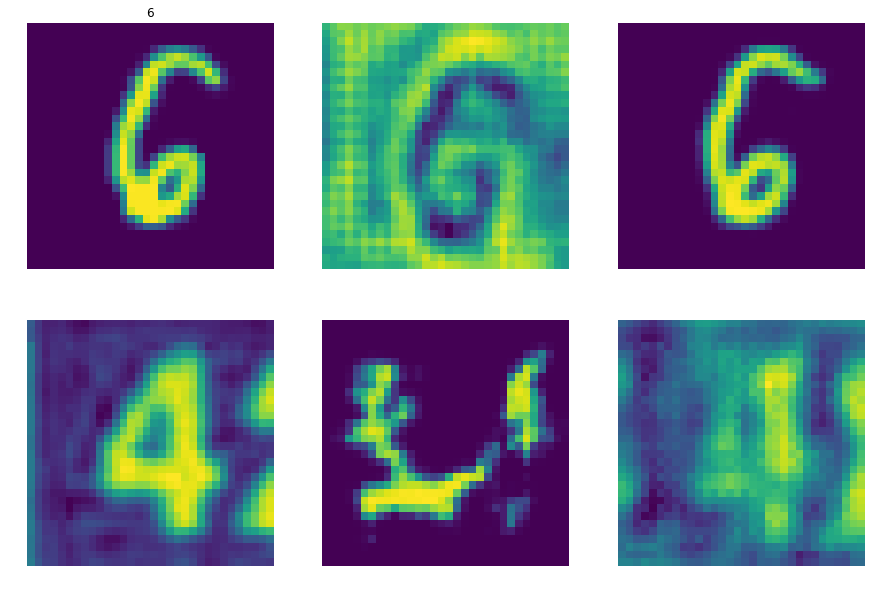

In [362]:
plt.rcParams['figure.figsize'] = (15, 10)
# plt.axes().set_aspect('equal', 'datalim')
#plt.axis([-3,3,-3,3])

index = 26
plt.subplot(2,3,1)
plt.title(Y_source_predict[index])
plt.imshow(X_source[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(X_s2t[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(X_s2s[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(X_target[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(X_t2s[index].reshape(32,32))
plt.axis('off')

plt.subplot(2,3,6)
#plt.imshow(np.transpose(X_target_trans[index].reshape(3,32,32), (1,2,0)))
plt.imshow(X_t2t[index].reshape(32,32))
plt.axis('off')

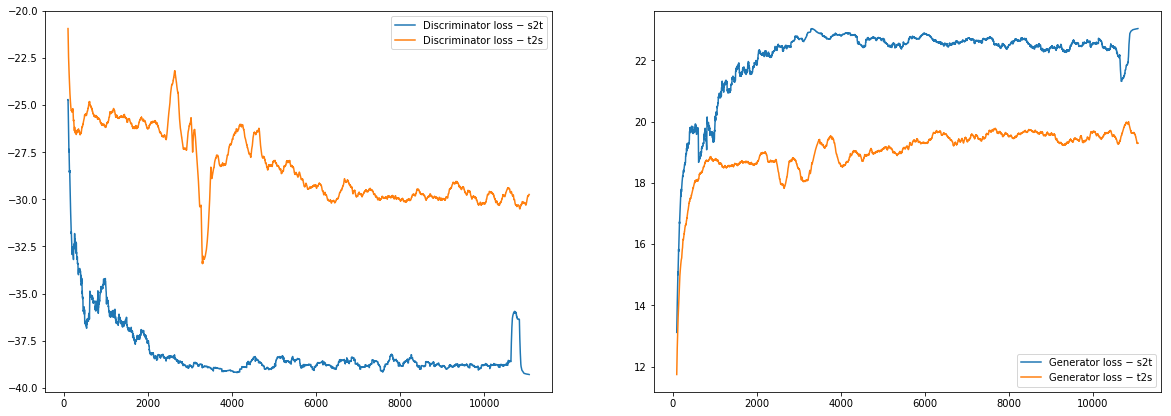

In [356]:
k = 100
start = 0
def smooth(x_list):
    res = [np.sum([x_list[k+j] for j in range(-k, k+1)])]
    for i in range(k+1, len(x_list)-k):
        res.append(res[-1] - x_list[i-k-1] + x_list[i+k])
    return np.array(res) / (2 * k)

plt.rcParams['figure.figsize'] = (20, 7)

plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(D_s2t_loss_list[start:]), label="Discriminator loss − s2t")
plt.plot(iter_list[k+start:-k], smooth(D_t2s_loss_list[start:]), label="Discriminator loss − t2s")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start:-k], smooth(G_s2t_loss_list[start:]), label="Generator loss − s2t")
plt.plot(iter_list[k+start:-k], smooth(G_t2s_loss_list[start:]), label="Generator loss − t2s")
plt.legend()

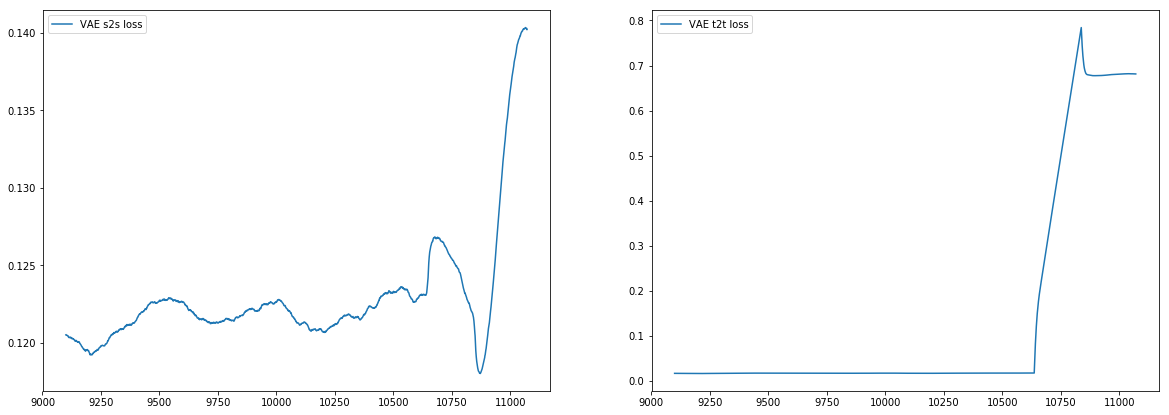

In [357]:
start = 9000
k = 100
plt.subplot(1,2,1)
plt.plot(iter_list[k+start:-k], smooth(vae_s2s_loss_list[start:]), label="VAE s2s loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iter_list[k+start:-k], smooth(vae_t2t_loss_list[start:]), label="VAE t2t loss")
plt.legend()

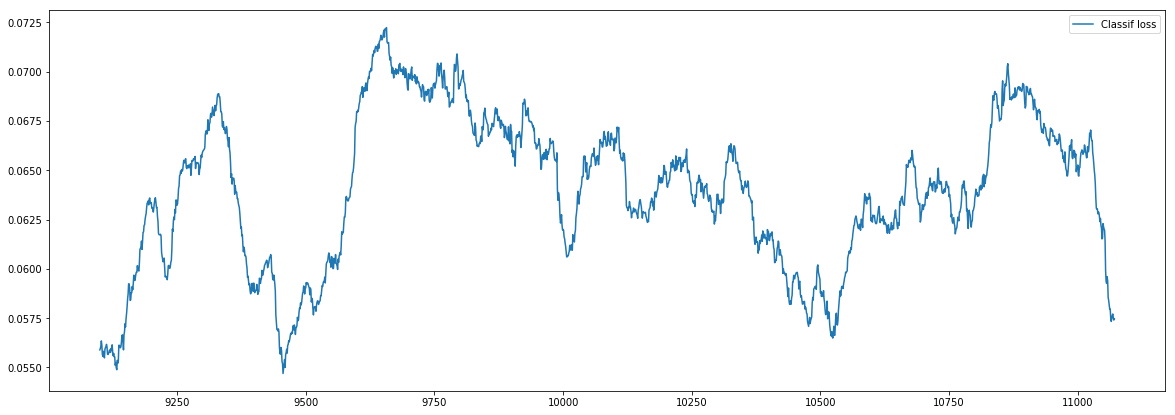

In [358]:
plt.plot(iter_list[k+start:-k], smooth(classif_t2s_loss_list[start:]), label="Classif loss")
plt.legend()

## Debug

In [ ]:
#X_target_trans[10][:,:,:]

### Gradients

In [69]:
print("Gradient of D with respect to", ipt_source)
gradient = sess.run(tf.gradients(discriminator(ipt_source, "source")[1], ipt_source), 
                    feed_dict={ipt_source: sample_source})
print("Min:", np.array(np.abs(gradient)).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(np.abs(gradient)).mean())

Gradient of D with respect to Tensor("ipt_source:0", shape=(?, 32, 32, 1), dtype=float32)
Min: 0.0
Max: 2.9901204
Avg: 0.13536564


In [70]:
ind = 0
print("Gradient of D with respect to", ipt_target)
gradient = sess.run(tf.gradients(discriminator(ipt_target, "target")[1], ipt_target), 
                    feed_dict={ipt_target: sample_target})

print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(np.abs(gradient)).mean())

Gradient of D with respect to Tensor("ipt_target:0", shape=(?, 32, 32, 1), dtype=float32)
Min: -1.117315
Max: 1.3139387
Avg: 0.06290068


In [71]:
ind = 1
print("Gradient with respect to", G_s2t_vars[ind])
gradient = sess.run(tf.gradients(G_s2t_loss, G_s2t_vars[ind]), feed_dict={ipt_source: sample_source, 
                                                                          ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

Gradient with respect to <tf.Variable 'source/encoder/conv2d/bias:0' shape=(64,) dtype=float32_ref>
Min: -0.0013320344
Max: 0.0021446005
Avg: 0.00010614042


In [72]:
ind = 2
print("Gradient with respect to", G_t2s_vars[ind])
gradient = sess.run(tf.gradients(G_t2s_loss, G_t2s_vars[ind]), feed_dict={ipt_source: sample_source, 
                                                                          ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

Gradient with respect to <tf.Variable 'target/encoder/instance_norm/conv1/scale:0' shape=(64,) dtype=float32_ref>
Min: -0.17529449
Max: 0.4636758
Avg: 0.00016781245


In [ ]:
D_s2t_vars[ind]

In [ ]:
D_s2t_vars

In [ ]:
X_test = sess.run([ipt_target_transf], feed_dict={ipt_source: sample_source, ipt_target: sample_target})[0][5]

In [ ]:
plt.imshow(X_test[:,:,0])

In [ ]:
gradient = sess.run(tf.gradients(gradient_penalty(ipt_source, "s2t"), ipt_source), feed_dict={ipt_source: sample_source})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())